### This question was asked by teacher Yao
- Why some classes always have higher accuracy in classification

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
class_accuracy = pd.read_csv('./merged_y_test_class_accuracy_new.csv')
print(class_accuracy.shape)
class_accuracy.head(2)

(140, 7)


,Unnamed: 0,num_mol2vec,class_in_train_mol2vec,accuray_in_each_class_mol2vec,accuray_in_each_class_parallel,accuray_in_each_class_tandem,accuray_in_each_class_random
0,10101010,5000,0,0.9316,0.7176,0.8394,0.4014
1,10101111,5000,0,0.9800,0.9410,0.8938,0.9086


In [8]:
class_accuracy[(class_accuracy.class_in_train_mol2vec==0) & (class_accuracy.num_mol2vec>=50)]

,Unnamed: 0,num_mol2vec,class_in_train_mol2vec,accuray_in_each_class_mol2vec,accuray_in_each_class_parallel,accuray_in_each_class_tandem,accuray_in_each_class_random
0,10101010,5000,0,0.931600,0.717600,0.839400,0.401400
1,10101111,5000,0,0.980000,0.941000,0.893800,0.908600
2,10111111,5000,0,0.872400,0.947200,0.881400,0.265600
3,11101010,5000,0,0.920800,0.964600,0.715800,0.306000
4,11000011,3826,0,0.980920,0.995557,0.965238,0.829848
5,10110110,2812,0,0.860242,0.995021,0.944523,0.417852
6,10101101,1337,0,0.940165,0.952880,0.362004,0.145101
7,10000111,1247,0,0.949479,0.973536,0.943063,0.855654
8,11111111,1218,0,0.893268,0.985222,0.951560,0.203612
40,10101000,230,0,0.986957,0.860870,0.386957,0.008696


In [6]:
mol2md = pd.read_csv('../../big-data/moses_dataset/result/mol2md_downsampled_max_5000.csv', index_col=0)
mol2md.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
cid,,,,,,,,
id924952,0,0,0,0,1,0,0,8
id57340,0,0,0,6,0,0,0,0


In [7]:
mol2md_class = mol2md.copy()
mol2md_class[mol2md_class >= 1] = 1
mol2md_class['class'] = mol2md_class.apply(lambda x: ''.join([str(i) for i in x]), axis=1)
mol2md_class.head()

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing,class
cid,,,,,,,,,
id924952,0,0,0,0,1,0,0,1,00001001
id57340,0,0,0,1,0,0,0,0,00010000
id777512,0,0,0,1,0,0,0,0,00010000
id851222,0,0,0,1,0,0,0,0,00010000
id851238,0,0,0,1,0,0,0,0,00010000


In [9]:
class_10101010 = mol2md_class[mol2md_class['class'] == '10101010']  # parallel model is worse
class_10101010.shape

(5000, 9)

In [10]:
class_11000011 = mol2md_class[mol2md_class['class'] == '11000011']  # similar
class_11000011.shape

(3826, 9)

In [11]:
class_110110 = mol2md_class[mol2md_class['class'] == '00110110']  # parallel model is much better
class_110110.shape

(58, 9)

In [22]:
class_110110.index.to_list()

['id20107',
 'id53217',
 'id53229',
 'id53232',
 'id55083',
 'id62381',
 'id64416',
 'id64431',
 'id82044',
 'id298612',
 'id490813',
 'id490814',
 'id490816',
 'id490818',
 'id490819',
 'id490827',
 'id493247',
 'id503613',
 'id503614',
 'id570309',
 'id676362',
 'id702474',
 'id702475',
 'id702476',
 'id702477',
 'id702478',
 'id702479',
 'id702480',
 'id702481',
 'id702482',
 'id702483',
 'id702484',
 'id702485',
 'id702486',
 'id702487',
 'id702489',
 'id702492',
 'id702493',
 'id702494',
 'id702495',
 'id702497',
 'id702498',
 'id702499',
 'id702500',
 'id702501',
 'id702502',
 'id702503',
 'id702504',
 'id702506',
 'id702507',
 'id702508',
 'id702510',
 'id850386',
 'id877529',
 'id1009358',
 'id1401013',
 'id1550934',
 'id1550949']

### get mol sentence by cid

In [29]:
def get_mol_sentence_by_cid(mol_sent_fp, selected_class, cid2smiles_fp=None, model_type='mol2vec', class_id=''):
    selected_cid2mol_sentence = {}
    inx2cid = {}
    cid_list = selected_class.index.to_list()
    result_fn = './table_4_1/class_{}_mol_sentence_model_{}.csv'.format(class_id, model_type)
    if cid2smiles_fp:
        cid2smiles = pd.read_csv(cid2smiles_fp, usecols=['cid'])
        inx2cid = cid2smiles['cid'].to_dict()
    with open(mol_sent_fp, 'r') as f_handle:
        for counter, each_row in enumerate(tqdm(f_handle)):
            each_row = each_row.strip()
            cid = ''
            mol_sent = ''
            if counter in inx2cid:
                cid = inx2cid[counter]
                mol_sent = each_row  # mol sentence is the whole row and seperated by space
            else:
                cid = each_row.split('\t')[0]
                mol_sent = ' '.join(each_row.split('\t')[1].split(','))  # mol sentence is the second part and seperated by ','
            if cid in cid_list:
                if model_type == 'parallel':
                    with open(result_fn, 'a') as f_handle2:
                        f_handle2.write(each_row + '\n')
                else:
                    selected_cid2mol_sentence[cid] = mol_sent
        if selected_cid2mol_sentence:
            selected_cid2mol_sentence_df = pd.DataFrame.from_dict(selected_cid2mol_sentence, orient='index')
            selected_cid2mol_sentence_df.to_csv(result_fn)
        # return selected_cid2mol_sentence_df

In [30]:
mol_sent_fp_mol2vec = '../../big-data/moses_dataset/model_mol2vec/cid2smiles_training_set_coupus_all_MOSES.txt'
cid2smiles_fp = '../../big-data/moses_dataset/raw_data/all_cid2smiles_moses.csv'
mol_sent_fp_parallel = '../../big-data/moses_dataset/result/step2_parallel_cid2smiles_sentence.csv'
class_id2class_df = {'10101010': class_10101010, '11000011': class_11000011, '110110': class_110110}

In [31]:
class_id = '10101010'
print('>>> class {}'.format(class_id))
print('  model mol2vec...')
get_mol_sentence_by_cid(mol_sent_fp=mol_sent_fp_mol2vec, cid2smiles_fp=cid2smiles_fp, 
                        selected_class=class_id2class_df[class_id], model_type='mol2vec', class_id=class_id)
print('  model parallel...')
get_mol_sentence_by_cid(mol_sent_fp=mol_sent_fp_parallel, 
                        selected_class=class_id2class_df[class_id], model_type='parallel', class_id=class_id)

>>> class 10101010
  model mol2vec...


1584663it [02:24, 10985.65it/s]
3286it [00:00, 16326.92it/s]

  model parallel...


13640898it [20:30, 11089.09it/s]


In [32]:
class_id = '11000011'
print('>>> class {}'.format(class_id))
print('  model mol2vec...')
get_mol_sentence_by_cid(mol_sent_fp=mol_sent_fp_mol2vec, cid2smiles_fp=cid2smiles_fp, 
                        selected_class=class_id2class_df[class_id], model_type='mol2vec', class_id=class_id)
print('  model parallel...')
get_mol_sentence_by_cid(mol_sent_fp=mol_sent_fp_parallel, 
                        selected_class=class_id2class_df[class_id], model_type='parallel', class_id=class_id)

class_id = '110110'
print('>>> class {}'.format(class_id))
print('  model mol2vec...')
get_mol_sentence_by_cid(mol_sent_fp=mol_sent_fp_mol2vec, cid2smiles_fp=cid2smiles_fp, 
                        selected_class=class_id2class_df[class_id], model_type='mol2vec', class_id=class_id)
print('  model parallel...')
get_mol_sentence_by_cid(mol_sent_fp=mol_sent_fp_parallel, 
                        selected_class=class_id2class_df[class_id], model_type='parallel', class_id=class_id)

>>> class 11000011
  model mol2vec...


1584663it [01:24, 18697.17it/s]
2138it [00:00, 21376.35it/s]

  model parallel...


13640898it [12:18, 18480.56it/s]


>>> class 110110
  model mol2vec...


1584663it [00:02, 552658.17it/s]
81340it [00:00, 402712.42it/s]

  model parallel...


13640898it [00:34, 400245.53it/s]


### cal length of mol sentence

In [33]:
def cal_len_mol_sent(class_id, model_type):
    fn = './table_4_1/class_{}_mol_sentence_model_{}.csv'.format(class_id, model_type)
    len_mol_sent = []
    with open(fn, 'r') as f_handle:
        for i in f_handle:
            if model_type == 'parallel':
                cid, mol_sent = i.strip().split('\t')
                frags = mol_sent.split(',')
                len_mol_sent.append(len(frags))
            if model_type == 'mol2vec':
                cid, mol_sent = i.strip().split(',')
                if mol_sent != '0':
                    frags = mol_sent.split(' ')
                    len_mol_sent.append(len(frags))
    print('There are {} sentences in this class'.format(len(len_mol_sent)))
    return len_mol_sent

In [40]:
class2len_mol_sent = {}
for class_id in class_id2class_df.keys():
    for model_type in ['mol2vec', 'parallel']:
        _ = pd.DataFrame(columns=['class_id', 'model_type', 'len_mol_sent'])
        _['len_mol_sent'] = cal_len_mol_sent(class_id, model_type)
        _['class_id'] = class_id
        _['model_type'] = model_type
        class2len_mol_sent[class_id + '-' + model_type] = _

There are 5000 sentences in this class
There are 47468 sentences in this class
There are 3826 sentences in this class
There are 9542 sentences in this class
There are 58 sentences in this class
There are 409 sentences in this class


In [44]:
class2len_mol_sent_df = pd.concat(list(class2len_mol_sent.values()))
class2len_mol_sent_df.shape

(66303, 3)

In [46]:
class2len_mol_sent_df.tail()

,class_id,model_type,len_mol_sent
404,110110,parallel,7
405,110110,parallel,6
406,110110,parallel,5
407,110110,parallel,4
408,110110,parallel,4


In [52]:
class2len_mol_sent_df2 = class2len_mol_sent_df.copy()
class2len_mol_sent_df2.loc[class2len_mol_sent_df['model_type']=='mol2vec', 'len_mol_sent'] = class2len_mol_sent_df2.loc[class2len_mol_sent_df['model_type']=='mol2vec', 'len_mol_sent'] - 30
class2len_mol_sent_df2.loc[class2len_mol_sent_df['model_type']=='mol2vec', 'model_type'] = 'mol2vec - 30'

In [47]:
class2len_mol_sent_df.to_csv('./table_4_1/class2len_mol_sentence_df.csv')

In [36]:
for key, values in class2len_mol_sent.items():
    with open('./table_4_1/class2len_mol_sentence.txt', 'a') as f_handle:
        f_handle.write(key + '\t' + ','.join([str(n) for n in values]) + '\n')

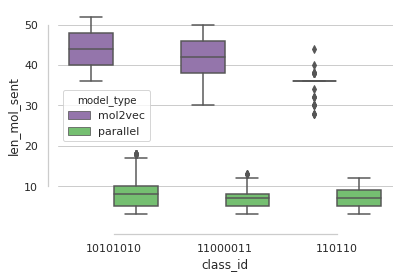

In [49]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# # Load the example iris dataset
# iris = sns.load_dataset("iris")

# # "Melt" the dataset to "long-form" or "tidy" representation
# iris = pd.melt(iris, "species", var_name="measurement")

sns.boxplot(x="class_id", y="len_mol_sent",
            hue="model_type", palette=["m", "g"],
            data=class2len_mol_sent_df)
sns.despine(offset=10, trim=True)

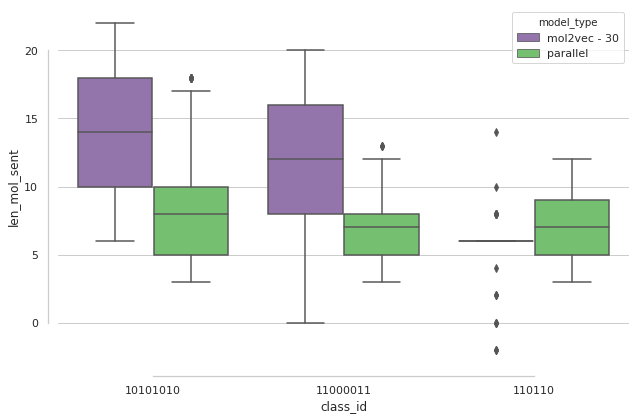

In [54]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# # Load the example iris dataset
# iris = sns.load_dataset("iris")

# # "Melt" the dataset to "long-form" or "tidy" representation
# iris = pd.melt(iris, "species", var_name="measurement")
plt.figure(figsize=(9, 6))
sns.boxplot(x="class_id", y="len_mol_sent",
            hue="model_type", palette=["m", "g"],
            data=class2len_mol_sent_df2)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig('./table_4_1/compare_sentence_len.png', dpi=200)

### get frequency of fragment in all MOSES data-set

In [58]:
def get_frag_in_class(class_id, model_type):
    fn = './table_4_1/class_{}_mol_sentence_model_{}.csv'.format(class_id, model_type)
    frag_in_class = {}
    with open(fn, 'r') as f_handle:
        for i in f_handle:
            frags = []
            if model_type == 'parallel':
                cid, mol_sent = i.strip().split('\t')
                frags = mol_sent.split(',')
                #len_mol_sent.append(len(frags))
            if model_type == 'mol2vec':
                cid, mol_sent = i.strip().split(',')
                if mol_sent != '0':
                    frags = mol_sent.split(' ')
            for frag in frags:
                frag_in_class[frag] = 0
                    # len_mol_sent.append(len(frags))
    print('There are {} fragments in this class'.format(len(frag_in_class)))
    return list(frag_in_class.keys())

In [59]:
class2frag = {}
for class_id in class_id2class_df.keys():
    for model_type in ['mol2vec', 'parallel']:
        _ = pd.DataFrame(columns=['class_id', 'model_type', 'fragment'])
        _['fragment'] = get_frag_in_class(class_id, model_type)
        _['class_id'] = class_id
        _['model_type'] = model_type
        class2frag[class_id + '-' + model_type] = _

There are 620 fragments in this class
There are 99 fragments in this class
There are 530 fragments in this class
There are 100 fragments in this class
There are 91 fragments in this class
There are 8 fragments in this class


In [60]:
class2frag_df = pd.concat(list(class2frag.values()))
class2frag_df.shape

(1448, 3)

In [63]:
class2frag_df.to_csv('./table_4_1/class2frag.csv')

In [61]:
class2frag_df.head()

,class_id,model_type,fragment
0,10101010,mol2vec,2246997334
1,10101010,mol2vec,3696402029
2,10101010,mol2vec,2246703798
3,10101010,mol2vec,535847852
4,10101010,mol2vec,2245384272


In [64]:
frag2num_parallel_model = pd.read_csv('./step2_parallel_frag2num_recount.csv', index_col='fragment', usecols=[1,2])
frag2num_parallel_model.head()

,count
fragment,
CC,23568756
CN,19360804
C,16215117
C=O,6971706
C1=CC=CC=C1,6809589


In [66]:
frag2num_parallel_model['freq'] = frag2num_parallel_model['count'] / frag2num_parallel_model['count'].sum()

In [67]:
frag2num_mol2vec = pd.read_csv('./frag2num_all_moses_model_mol2vec.csv', index_col='fragment')
frag2num_mol2vec.head()

,count
fragment,
3218693969,8074516
3217380708,6319726
951226070,4145346
2968968094,2711673
2246728737,2572786


In [68]:
frag2num_mol2vec['freq'] = frag2num_mol2vec['count'] / frag2num_mol2vec['count'].sum()

In [69]:
frag2freq = pd.concat([frag2num_parallel_model, frag2num_mol2vec])
print(frag2freq.shape)
frag2freq.head()

(3732, 2)


,count,freq
fragment,,
CC,23568756,0.231374
CN,19360804,0.190065
C,16215117,0.159184
C=O,6971706,0.068441
C1=CC=CC=C1,6809589,0.066850


In [70]:
class2frag_freq = class2frag_df.merge(frag2freq, left_on='fragment', right_index=True)
class2frag_freq.head()

,class_id,model_type,fragment,count,freq
0,10101010,mol2vec,2246997334,21045,0.000307
1,10101010,mol2vec,3696402029,19098,0.000278
2,10101010,mol2vec,2246703798,28179,0.000411
3,10101010,mol2vec,535847852,18726,0.000273
4,10101010,mol2vec,2245384272,2121169,0.030924


In [76]:
class2frag_freq.to_csv('./table_4_1/class2fragment_frequency.csv')

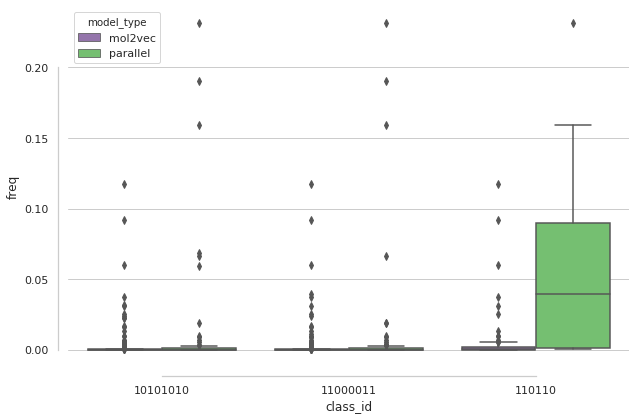

In [74]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# # Load the example iris dataset
# iris = sns.load_dataset("iris")

# # "Melt" the dataset to "long-form" or "tidy" representation
# iris = pd.melt(iris, "species", var_name="measurement")
plt.figure(figsize=(9, 6))
sns.boxplot(x="class_id", y="freq",
            hue="model_type", palette=["m", "g"],
            data=class2frag_freq)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig('./table_4_1/compare_frag_frequency.png', dpi=200)

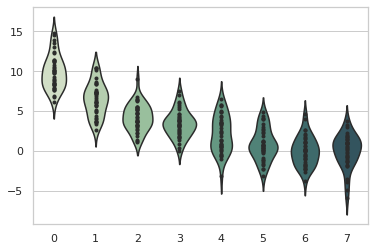

In [71]:
# Create a random dataset across several variables
rs = np.random.RandomState(0)
n, p = 40, 8
d = rs.normal(0, 2, (n, p))
d += np.log(np.arange(1, p + 1)) * -5 + 10

# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(p, rot=-.5, dark=.3)

# Show each distribution with both violins and points
sns.violinplot(data=d, palette=pal, inner="points")

In [73]:
d.shape

(40, 8)